# Faire une carte avec les DROM rapprochés grâce à cartiflette

Lino Galiana

<div class="alert alert-danger" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-triangle-exclamation"></i> Important</h3>

Cette page est un *work in progress*! Des exemples dans d’autres
langages que `Python` viendront ultérieurement.

Cette page fait partie d’une série de tutoriels illustrant les
fonctionnalités de `cartiflette`. Pour retrouver la liste de ceux-ci,
c’est [ici](../use-case/index.qmd)

</div>

Ce tutoriel vise à illustrer un cas d’usage classique de `cartiflette` :
**récupérer de manière flexible un fonds de carte dont les
<span class="yellow">DROM sont rapprochés</span> et où on voit
<span class="yellow">un zoom sur l’Ile de France</span>**.

Ce besoin classique est illustré en répliquant la carte faite par [Jules
Grandin pour son podcast “La Minute
Cartographique”](https://www.youtube.com/watch?v=mK7Hr2x895k) L’objectif
final de ce tutoriel est de faire cette carte:

Voir l’épisode en question de “La Minute Cartographique”

<https://www.youtube.com/embed/mK7Hr2x895k?si=6nNRsJziuUjGsP5B>

# 1. Préliminaire: récupération des cheptels français

La vidéo de Jules Grandin évoque une ouverture et préparation des
données dans Excel 😱. Néanmois, en quelques lignes de code, on peut
render ces données propres à l’analyse statistique et cartographique
avec `Python` 😌

In [1]:
import pandas as pd

def import_cheptel():
    url_cheptel = "https://www.insee.fr/fr/statistiques/fichier/2012795/TCRD_073.xlsx"

    cheptel2022 = pd.read_excel(url_cheptel, header=3, na_values="nd")
    type_cheptel = cheptel2022.columns[~cheptel2022.columns.str.startswith("Unnamed")]
    cheptel2022.loc[:, type_cheptel] = cheptel2022.loc[:, type_cheptel].mul(1000)
    cheptel2022 = cheptel2022.rename(
        {
            "Unnamed: 0": "code",
            "Unnamed: 1": "departement",
            "Volailles gallus": "Volailles",
        },
        axis="columns",
    )
    type_cheptel = type_cheptel.str.replace(" gallus", "")
    return cheptel2022, type_cheptel

cheptel = import_cheptel()

cheptel[0].head(4)

En ce qui concerne la population, qui nous servira au dénominateur de
notre indicateur, nous allons utiliser la variable fournie dans les
données récupérées par le biais de `cartiflette`[1].

# 2. Récupérer les contours modifiés via `cartiflette`

## 2.1 La récupération des données utilisant `cartiflette`

Notre objectif est de faire une carte aux caractéristiques suivantes:

-   Les DROM sont rapprochés de la France hexagonale en étant placés
    sous celle-ci ;
-   Un cartogramme zoomé de la petite couronne parisienne (départements
    de la Seine, Hauts-de-Seine, Seine-Saint-Denis et Val de Marne) est
    disponible en haut à gauche de celle-ci.

Construire soi-même ce fonds de carte est fastidieux, comme l’illustre
la partie [Comment faire sans cartiflette](#sans-cartiflette). Avec
`cartiflette`, ce fonds de carte est préconstruit à partir des
découpages officiels de l’IGN. Il suffit de remplace le niveau
`FRANCE_ENTIERE` en `FRANCE_ENTIERE_DROM_RAPPROCHES` dans l’appel à
`carti_download`.

``` python
from cartiflette import carti_download

departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)
```

Listing 1: Example d’utilisation de cartiflette

`departements` est un `GeoDataFrame` classique proposant les métadonnées
usuelles de `cartiflette` avec des géographies modifiées pour rapprocher
la France des DROM[2].

[1] Dans l’idéal, nous utiliserions les [populations
légales](https://www.insee.fr/fr/statistiques/7728787?sommaire=7728826)
mesurées par l’Insee. Les fonds de carte de l’IGN proposent néanmoins
déjà une variable `POPULATION` qui est celle qui sera utilisée ici. Des
travaux ultérieurs sur `cartiflette` viseront à remplacer cette variable
par les populations légales pour assurer que les métadonnées utilisées
par les fonds de carte correspondent, au même titre que les découpages
géométriques, aux données officielles.

[2] Ce fonds de carte est en géométrie WGS84 (CRS: 4326). Ce n’est
néanmoins qu’une apparence car les géométries nécessaires pour
représenter les DROM et l’Ile de France sur cette carte ne correspondent
à aucune réalité terrestre. Il ne faut donc considérer ce fonds de carte
que pour la cartographie finale, pas la manipulation de données
géographique (par exemple pour un calcul de distance terrestre). Pour
celles-ci, le fonds de carte normal à utiliser est `FRANCE_ENTIERE`.

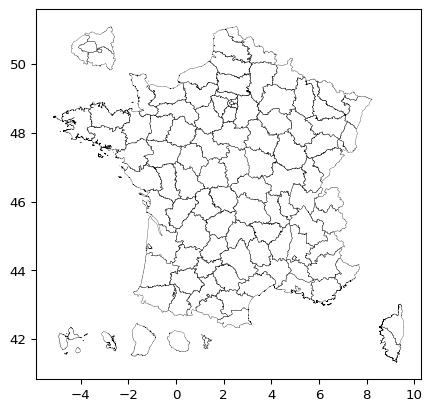

In [5]:
departements.boundary.plot(edgecolor = "black", linewidth=0.2)

## 2.2 Association du fonds de carte `cartiflette` au jeu de données initial

La suite du travail n’est pas intrinsèquement lié à `cartiflette` mais
correspond à de la manipulation de données spatiales nécessaires à la
finalisation de la carte.

Comme nous avons besoin de localiser les décomptes départements de
bétail, nous faisons une jointure spatiale entre notre fonds de carte et
nos cheptels

In [6]:
cheptel_geospatial = departements.merge(
    cheptel[0], left_on="INSEE_DEP", right_on = "code"
)

A partir de là, on finalise notre travail sur le jeu de données pour
calculer le ratio entre le nombre de têtes et la population:

In [7]:
def ratio_cheptel(type_cheptel, data_departement):
    """
    Fonction permettant de rapporter, pour un type de bête donné,
    le nombre de têtes par habitant d'un département 
    """
    data_departement = data_departement.copy()
    data_departement["ratio_" + type_cheptel] = (
        data_departement.loc[:, type_cheptel]
        .div(data_departement["POPULATION"], axis=0)
    )
    data_departement["more_" + type_cheptel] = (
        data_departement["ratio_" + type_cheptel] > 1
    )
    return data_departement.loc[:, "more_" + type_cheptel]

eval_ratio = pd.concat(
    [ratio_cheptel(bete, cheptel_geospatial) for bete in cheptel[1]],
    axis = 1
)

cheptel_geospatial = pd.concat(
    [cheptel_geospatial, eval_ratio],
    axis = 1
)

Le jeu de données prêt à l’emploi prend la forme suivante:

In [8]:
cheptel_geospatial.head(2)

## 2.3 Production de la carte interactive

On peut maintenant se concentrer sur la carte. Pour la rendre plus
informative, il est utile de contextualiser les départements en
permettant aux spectateurs de la carte de connaître le nom des
départements ayant un cheptel plus important que sa population.

Cela peut être fait comme sur la carte d’origine de Jules Grandin en
inscrivant les noms des départements concernés sur celle-ci. Cela
nécessite tout de même un travail manuel important pour qui n’utilise
pas une interface comme QGIS.

Il est plus simple, pour les utilisateurs de logiciels comme `Python`,
`R` ou `Javascript` de produire une carte interactive qui permet
d’afficher des valeurs lorsqu’on passe la souris dessus. Il existe
plusieurs écosystèmes pour faire cela, plus ou moins directement reliés
à `Javascript`, le langage consacré pour ce type d’applications
réactives.

Les exemples ci-dessous proposent un code en `Python` pour faire une
carte interactive par le biais de la librairie `Folium`. Cette manière
de procéder étant un peu fastidieuse, car `Folium` n’est pas
initialement conçu pour ce type de cartes, il est recommandé de
privilégier la solution `Observable` qui est un *framework* `Javascript`
ressemblant beaucoup à `Python` mais plus adapté que ce dernier pour la
*dataviz*.

En premier lieu, on définit une fonction générique qui permet de
construire, pour un type de cheptel donné, la carte qui sera créée:

In [9]:
import folium
import branca

palettes = {
    "Bovins": {True: "#f9b439", False: "#d8d4d3"},
    "Porcins": {True: "#ec6569", False: "#d8d4d3"},
    "Ovins": {True: "#5eb04e", False: "#d8d4d3"},
    "Caprins": {True: "#5eb04e", False: "#d8d4d3"}
}

# Function to apply color based on the 'more_XXXXX' values
def style_function(feature, bete):
    more_bovins = feature['properties'][f'more_{bete}']
    return {
        'fillColor': palettes[bete][more_bovins],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }


def map_repartition(cheptel_geospatial, bete):
    white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])

    # Initialize a folium map
    m = folium.Map(
        location=[
            cheptel_geospatial.geometry.centroid.y.mean(), cheptel_geospatial.geometry.centroid.x.mean()
        ],
        zoom_start=5,
        tiles=white_tile, attr="white tile"
    )


    # Add GeoJson layer to the map
    folium.GeoJson(
        cheptel_geospatial,
        style_function=lambda x: style_function(x, bete),
        tooltip=folium.GeoJsonTooltip(
            fields=['LIBELLE_DEPARTEMENT', 'POPULATION', bete],
            aliases=['Department:', 'Population:', f'{bete}:'],
            localize=True
        )
    ).add_to(m)

    return m

Pour créer celles-ci, il suffit dès lors d’appliquer la fonction sur le
type d’élevage désiré:

In [10]:
map_repartition(cheptel_geospatial, "Bovins")
map_repartition(cheptel_geospatial, "Porcins")
map_repartition(cheptel_geospatial, "Ovins")

Néanmoins, ce n’est pas la méthode adoptée pour créer les cartes
ci-dessous:

Pour cela, il vaut mieux utiliser `Javascript` par le biais
d’`Observable` dont le code est disponible dans la boite déroulable
ci-dessous:

> **Comment faire avec `Javascript` ?**
>
> Ce tutoriel utilise le *framework* `Observable` par le biais de
> `Quarto`, l’outil de construction de site web développé par `Posit`.
> Le code source de cette page est disponible
> [ici](https://github.com/InseeFrLab/cartiflette-website/blob/master/use-case/usecase2.qmd)[1].
>
> Pour se simplifier la tâche, on va créer une fonction graphique qui
> prend en *input* un `Array` et un type d’élevage (par exemple
> *“Bovins”*) et renvoie une carte:
>
> Celle-ci utilise un certain nombre d’ingrédients. En premier lieu, des
> *arrays* permettant de changer les valeurs affichées en fonction de la
> valeur du *widget* sélectionné :
>
> ``` js
> labels = [
>     {type: "Bovins", true: "Plus de vaches 🐮", false: "Plus d'habitants"},
>     {type: "Porcins", true: "Plus de cochons 🐷", false: "Plus d'habitants"},
>     {type: "Ovins", true: "Plus de moutons 🐑", false: "Plus d'habitants"},
>     {type: "Caprins", true: "Plus de chèvres 🐐", false: "Plus d'habitants"}
> ]
> title = [
>     {type: "Bovins", title: "Plus de vaches 🐮 ou d'habitants ?"},
>     {type: "Porcins", title: "Plus de cochons 🐷 ou d'habitants ?"},
>     {type: "Ovins", title: "Plus de moutons 🐑 ou d'habitants ?"},
>     {type: "Caprins", title: "Plus de chèvres 🐐 ou d'habitants ?"}
> ]
> palettes = [
>     {
>         name: "Bovins",
>         trueColor: "#f9b439",
>         falseColor: "#d8d4d3"
>     },
>     {
>         name: "Porcins",
>         trueColor: "#ec6569",
>         falseColor: "#d8d4d3"
>     },
>     {
>         name: "Ovins",
>         trueColor: "#5eb04e",
>         falseColor: "#d8d4d3"
>     },
>     {
>         name: "Caprins",
>         trueColor: "#00b5ed",
>         falseColor: "#d8d4d3"
>     }
> ]
>
> title_chosen = title.filter(d => d.type == bete)[0].title
> ```
>
> Ce *widget* est un [radio
> button](https://developer.mozilla.org/fr/docs/Web/HTML/Element/input/radio)
> qui peut être créé par le code suivant, permettant à la fois d’exposer
> celui-ci sur l’interface et de stocker sa valeur active dans la
> variable `bete`
>
> ``` js
> viewof bete = Inputs.radio(
>     new Map([["Vaches 🐮", "Bovins"], ["Cochons 🐷", "Porcins"], ["Moutons 🐑", "Ovins"]]), {value: "Bovins"}
> )
> ```
>
> Il ne manque qu’à importer les données nécessaires à la carte dans
> `Javascript`. La fonction
> [`ojs_define`](https://quarto.org/docs/interactive/ojs/data-sources.html)
> permettant la transmission d’un objet `Python` à `R` ne fonctionnant
> pas pour un `GeoPandas`, le plus simple est de créer un GeoJSON en
> `Python` :
>
> ``` python
> cheptel_geospatial.to_file(
>     "cheptel.json", driver="GeoJSON"
> )
> ```
>
> Il suffit ensuite d’importer celui-ci avec la fonction
> [`FileAttachment`](https://quarto.org/docs/interactive/ojs/data-sources.html)
> d’`Observable`
>
> ``` js
> cheptel = FileAttachment("cheptel.json").json()
> ```

# 3. Comment faire sans `cartiflette` ?

-   1️⃣ Télécharger les données et les enregistrer sur le disque, en
    local.
-   2️⃣ Dézipper la version téléchargée (le format est une archive 7z) et
    enregistrer l’arborescence obtenue sur le disque.
-   3️⃣ Importer le bon *shapefile* dans `Python` et découper celui-ci en
    différents espaces qui seront reprojetés
-   4️⃣ Pour chaque DROM et département de l’Île de France, modifier la
    géométrie en jouant sur des translations et rotations
-   5️⃣ Consolider le fond de carte à partir des différents éléments
    obtenus

La première étape consiste donc à télécharger le fichier depuis le site
de mise à disposition de l’IGN. L’archive étant assez volumineuse, le
code proposé propose une barre de progrès pour s’assurer que le
téléchargement progresse.

Le code étant assez long, il n’est pas apparent par défaut mais il
suffit de cliquer ci-dessous:

``` python
import os
import requests
import py7zr
from tqdm import tqdm

# Step 1: Download the file with progress bar
url = "https://data.geopf.fr/telechargement/download/ADMIN-EXPRESS-COG-CARTO/ADMIN-EXPRESS-COG-CARTO_3-1__SHP_WGS84G_FRA_2022-04-15/ADMIN-EXPRESS-COG-CARTO_3-1__SHP_WGS84G_FRA_2022-04-15.7z"
file_name = url.split("/")[-1]

def download_7z_archive(file_name):
    if os.path.exists(file_name) is False:
        # Streaming download with progress bar
        print("Downloading file...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(file_name, 'wb') as file, tqdm(
                desc=file_name,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for chunk in response.iter_content(chunk_size=8192):
                size = file.write(chunk)
                bar.update(size)

        print(f"Downloaded {file_name}")
        return file_name
    else:
        print("File exists, please delete it before going further")

download_7z_archive(file_name)
```

Listing 2: 1️⃣ Code pour télécharger les données

La deuxième étape consiste à dézipper la version téléchargée en local

``` python
def extract_7z_archive(
    file_name, output_dir = "extracted_files"
):
    # Step 2: Extract the .7z file
    os.makedirs(output_dir, exist_ok=True)

    print("Extracting the file...")
    with py7zr.SevenZipFile(file_name, mode='r') as z:
        z.extractall(path=output_dir)
    print(f"Extracted to {output_dir}")
    return output_dir

extract_7z_archive(file_name)
```

Listing 3: 2️⃣ Dézipper la version téléchargée

[1] `Javascript` est un langage asynchrone donc l’exécution du code ne
dépend pas de l’ordre de définition des objets dans le code,
contrairement à `Python`. Il est donc normal de voir dans les codes
ci-dessous une utilisation d’une variable, par exemple `bete`, qui n’est
pas définie en amont. Celle-ci peut être définie plus loin dans le code,
c’est `Javascript` qui va réordonner de manière logique l’exécution du
code.

In [14]:
import geopandas as gpd

path_extraction = "./extracted_files/ADMIN-EXPRESS-COG-CARTO_3-1__SHP_WGS84G_FRA_2022-04-15/ADMIN-EXPRESS-COG-CARTO/1_DONNEES_LIVRAISON_2022-04-15/ADECOGC_3-1_SHP_WGS84G_FRA/"

# Limites communales
france = gpd.read_file(f"{path_extraction}/COMMUNE.shp")
hexagone = france.loc[
    ~france["INSEE_DEP"].isin(["971", "972", "973", "974", "976"])
]
guadeloupe = france.loc[france["INSEE_DEP"] == "971"]
martinique = france.loc[france["INSEE_DEP"] == "972"]
guyane = france.loc[france["INSEE_DEP"] == "973"]
reunion = france.loc[france["INSEE_DEP"] == "974"]
mayotte = france.loc[france["INSEE_DEP"] == "976"]